Identified Estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                
──────────────────(E[spending_score|age])
d[annual_incoming]                       
Estimand assumption 1, Unconfoundedness: If U→{annual_incoming} and U→spending_score then P(spending_score|annual_incoming,age,U) = P(spending_score|annual_incoming,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
Causal Effect using DoWhy: 0.0005215716805508919
Average Treatment Effect from Double Machine Learning (DML): 0.0005621901377768476


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


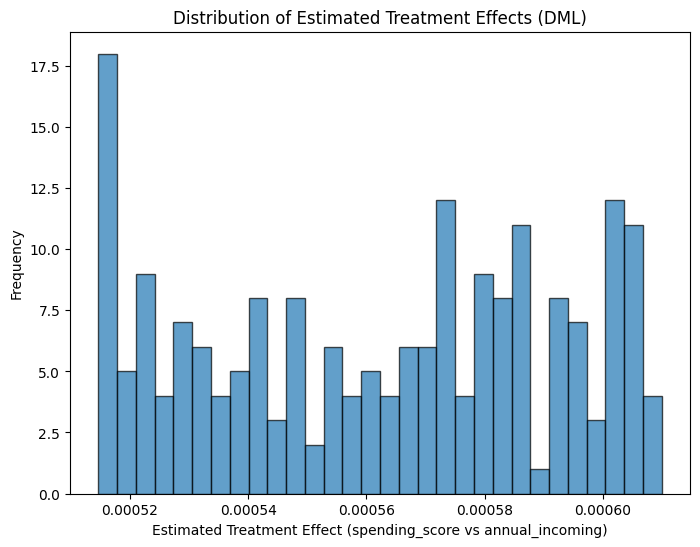

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import dowhy
from dowhy import CausalModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from econml.dml import LinearDML
from sklearn.model_selection import train_test_split

# Step 1: Data Generation (or use your actual dataset)
np.random.seed(0)
n = 1000
data = pd.DataFrame({
    "customer_id": np.arange(n),
    "age": np.random.randint(18, 70, size=n),
    "annual_incoming": np.random.normal(50000, 10000, size=n),
    "spending_score": np.random.normal(50, 15, size=n)
})

# Assume spending score is influenced by age and annual income
data['spending_score'] += 0.5 * \
    data['annual_incoming'] / 1000 - 0.2 * data['age']

# Step 2: Define the Causal Model using DoWhy
model = CausalModel(
    data=data,
    treatment="annual_incoming",
    outcome="spending_score",
    common_causes=["age"]
)

# Identify the causal effect
identified_estimand = model.identify_effect()

# Step 3: Double Machine Learning (DML) using EconML
# Split data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=0)

# Define the models for treatment and outcome
model_t = RandomForestRegressor()  # Model for treatment (annual_incoming)
model_y = RandomForestRegressor()  # Model for outcome (spending_score)

# Use LinearDML as the double machine learning estimator
dml_estimator = LinearDML(model_y=model_y, model_t=model_t)

# Fit the model
dml_estimator.fit(Y=train_data["spending_score"],
                  T=train_data["annual_incoming"],
                  X=train_data[["age"]])

# Estimate the treatment effect on the test set
treatment_effects = dml_estimator.effect(test_data[["age"]])

# Step 4: Show Results
# Print the identified estimand
print(f"Identified Estimand: {identified_estimand}")

# Estimate the treatment effect using DoWhy (Simple estimation)
estimate = model.estimate_effect(
    identified_estimand, method_name="backdoor.linear_regression")
print(f"Causal Effect using DoWhy: {estimate.value}")

# Print the treatment effect from the DML model (on test data)
print(
    f"Average Treatment Effect from Double Machine Learning (DML): {np.mean(treatment_effects)}")

# Optional: Evaluate DML's performance (e.g., plotting the heterogeneous treatment effects)

plt.figure(figsize=(8, 6))
plt.hist(treatment_effects, bins=30, edgecolor="k", alpha=0.7)
plt.title("Distribution of Estimated Treatment Effects (DML)")
plt.xlabel("Estimated Treatment Effect (spending_score vs annual_incoming)")
plt.ylabel("Frequency")
plt.show()

Model LogisticRegressionCV(cv=5, max_iter=1000) has a non-default cv attribute, which will be ignored
Model LogisticRegressionCV(cv=5, max_iter=1000) has a non-default cv attribute, which will be ignored
Model LogisticRegressionCV(cv=5, max_iter=1000) has a non-default cv attribute, which will be ignored


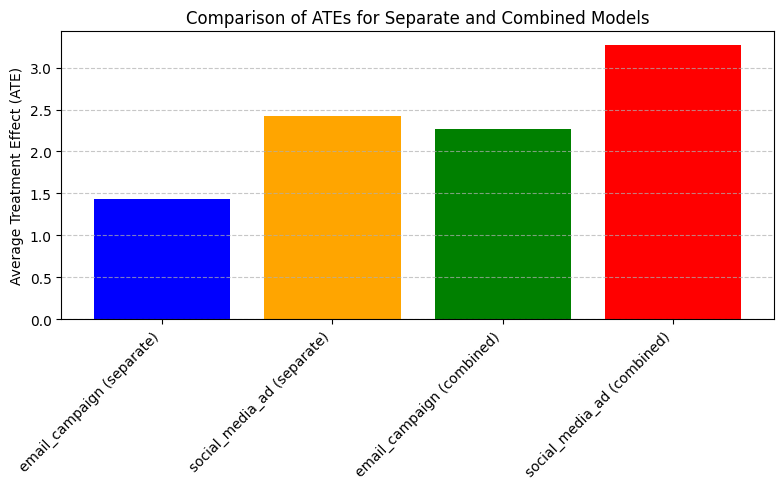

ATE for email_campaign (separate): 1.428
ATE for social_media_ad (separate): 2.424
ATE for email_campaign (combined): 2.267
ATE for social_media_ad (combined): 3.269


In [1]:
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegressionCV
import numpy as np
import matplotlib.pyplot as plt

# Simulated data
np.random.seed(42)
n = 1000
X = np.random.normal(size=(n, 5))
email_campaign = np.random.binomial(1, 0.5, size=n)
social_media_ad = np.random.binomial(1, 0.5, size=n)
Y = 2 * email_campaign + 3 * social_media_ad - 1.5 * email_campaign * social_media_ad + np.dot(X, [0.5, 0.2, -0.3, 0, 0]) + np.random.normal(size=n)

# Combined treatment
T_combined = np.where(
    (email_campaign == 1) & (social_media_ad == 0), 2,
    np.where((email_campaign == 0) & (social_media_ad == 1), 1,
             np.where((email_campaign == 1) & (social_media_ad == 1), 3, 0))
)

# Base learners
model_t = LogisticRegressionCV(cv=5, max_iter=1000)
model_y = RandomForestRegressor(n_estimators=100, random_state=42)

# Separate models
dml_email = CausalForestDML(model_y=model_y, model_t=model_t, discrete_treatment=True, random_state=42)
dml_social = CausalForestDML(model_y=model_y, model_t=model_t, discrete_treatment=True, random_state=42)

dml_email.fit(Y, email_campaign, X=X)
dml_social.fit(Y, social_media_ad, X=X)

ate_email = dml_email.ate(X)
ate_social = dml_social.ate(X)

# Combined model
dml_combined = CausalForestDML(model_y=model_y, model_t=model_t, discrete_treatment=True, random_state=42)
dml_combined.fit(Y, T_combined, X=X)

ate_combined_email = dml_combined.effect(X, T0=0, T1=2)
ate_combined_social = dml_combined.effect(X, T0=0, T1=1)

# Mean ATEs
mean_ate_email = np.mean(ate_email)
mean_ate_social = np.mean(ate_social)
mean_ate_combined_email = np.mean(ate_combined_email)
mean_ate_combined_social = np.mean(ate_combined_social)

# Plotting
categories = ['email_campaign (separate)', 'social_media_ad (separate)',
              'email_campaign (combined)', 'social_media_ad (combined)']
values = [mean_ate_email, mean_ate_social, mean_ate_combined_email, mean_ate_combined_social]

plt.figure(figsize=(8, 5))
plt.bar(categories, values, color=['blue', 'orange', 'green', 'red'])
plt.ylabel('Average Treatment Effect (ATE)')
plt.title('Comparison of ATEs for Separate and Combined Models')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print results
print(f"ATE for email_campaign (separate): {mean_ate_email:.3f}")
print(f"ATE for social_media_ad (separate): {mean_ate_social:.3f}")
print(f"ATE for email_campaign (combined): {mean_ate_combined_email:.3f}")
print(f"ATE for social_media_ad (combined): {mean_ate_combined_social:.3f}")
